## Density Field Analysis of Environment around DLAs
This code computes the overdensity in the environment of a DLA-host Halo by shooting lines of sight along the Halos of interest and plotting the overdensity along it.<br>
The density field file is a CIC approximation as given by Aseem. CIC is of the same snapshot from which the Mock Halo catalogue for 2PC was extracted.<br>
The simulation box is treated to be Periodic.<br>
The algorithm followed by this code is -<br>
<ul>
    <li>Choose set of random halos from each of the 3 catalogues given.</li>
    <li>Choose random non-zero parameters P=(Ai,Bi,Ci) for the current run. With the position of the center of the halo H=(X0,Y0,Z0), create an array of tuples (Xi,Yi,Zi) which are points sampled along the 3D line traced by P and H. The length predefined is 150MPc, centered at the center of the Halo (H).</li>
    <li>Find the overdensity values interpolated at these new set of points and plot them as overdensity along the line of sight. Important to take into account Periodic Boundary considerations.</li>
</ul>
Encoded in Analyse mode <i>"general"</i><br>
<br>
<i>Update: 14th May, 2019 <br></i>
One alternative to the above method is to draw a line of sight parallel to either of the x,y,z axes, with points lying on the grid corners so that interpolation of CIC is not required.<br>

Encoded in Analyse mode <i>"simple"</i><br>

<i>Update: 16th May, 2019</i><br>
Aim of this analysis is to move towards a more statistically robust estimate of clustering around the environment of the Halos of interest. The updated exercise is as follows-
<ul>
    <li>Shoot lines of sight parallel to one of the axes for all the halos in the given catalogues.</li>
    <li>Find the Overdensity amplitude values at all the points on these lines with the Halo of interest at the center.</li>
    <li>Find the mean at each scale and produce a plot with mean values and standard deviation for each "r" for each catalogue.</li>
    <li>Can be extended to be more robust by shooting L.O.S. from all 3 directions to triple the DF values.</li>
</ul>

Note: The direction wouldn't matter in such averaging from the isotropic assumption for our Universe, hence, no need to worry about the Line inclined correctly. On an average it should give a good representation of the real situation.<br>
<br>
Encoded in Analyse mode <i>"averaged"</i>

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import RegularGridInterpolator as rgi

colors=['g','b','r']
sourcePath="../SourceData/"  # Will not become a member of the git commits because CIC file is 1.1GB
fileNames=['b1','b1alpha','b1T10']
# Loading CIC data of density field. (512^3)
GridSize=512  # cubed of course.
cicSource="cic_snap049_grid512.dat"
data1=np.fromfile(sourcePath+cicSource)
data=np.reshape(data1,(GridSize,GridSize,GridSize))

In [2]:
# Aseem's Cosmology
sigma_8=0.811
ns=0.961
h=0.7
Ob=0.045
Om=0.276

z=2.3         # Redshift specification
M_sun=1.989e+30  # M_sun in kg
Mega_parsec=3.086e+22  # parsec in metres
Delta=200.0   # Overdensity definition = Delta X background
rho_cr=((3*(100*h)**2)/(8*np.pi*6.673e-11))*((Mega_parsec/h**3)*1e+6/(M_sun/h))
# critical density of the Universe today 3H^2/8Pi*G in units M_sun.h^-1/(MPc.h^-1)^3
rho_m=Om*rho_cr*((1+z)**3)  # where a=1/(1+z)   Units same as rho_cr
del_crit=1.69
Lbox=150.0   # MPc/h

In [3]:
# Choosing 1 random halo from each Mock Catalogue
def pickHalo():
    pickedHalos=[]    # to store randomly picked halos
    for name in fileNames:
        mocks=pickle.load(open(sourcePath+name+'.pickled','rb'))
        r=int(np.floor(float(np.random.rand(1))*mocks[:,0].size))
        pickedHalos.append(mocks[r])
    return(np.array(pickedHalos))

In [4]:
# A reverse CIC function to interpolate value at the given point from the CIC grid
def revCIC(p):
    
    result=0.0
    p_grid=p
    p_grid[p_grid>=Lbox]=p_grid[p_grid>=Lbox]-Lbox  # Periodicity considerations
    #p_grid[p_grid<0.0]=p_grid[p_grid<0.0]+Lbox    # Periodicity considerations
    p_grid=(GridSize-1)*p_grid/Lbox                   # Halo co-ods to grid co-ods
    x,y,z=p_grid[0],p_grid[1],p_grid[2]
    
    p_=np.floor(p_grid)
    x_,y_,z_=int(p_[0]),int(p_[1]),int(p_[2])
    
    result+=data[x_,y_,z_]*(x_+1-x)*(y_+1-y)*(z_+1-z)
    result+=data[x_+1,y_,z_]*(x-x_)*(y_+1-y)*(z_+1-z)
    result+=data[x_,y_+1,z_]*(x_+1-x)*(y-y_)*(z_+1-z)
    result+=data[x_,y_,z_+1]*(x_+1-x)*(y_+1-y)*(z-z_)
    result+=data[x_+1,y_+1,z_]*(x-x_)*(y-y_)*(z_+1-z)
    result+=data[x_+1,y_,z_+1]*(x-x_)*(y_+1-y)*(z-z_)
    result+=data[x_,y_+1,z_+1]*(x_+1-x)*(y-y_)*(z-z_)
    result+=data[x_+1,y_+1,z_+1]*(x-x_)*(y-y_)*(z-z_)
    
    return result

In [5]:
#LOS Method implemented does an interpolation of the CIC in a randomly picked 3D line

sign=lambda x,y: -1 if x<y else 1

def generalLOS(halo):
    pos,df=[],[]
    grain=250
    
    params=np.random.rand(3)*10
    t=Lbox*0.5/(np.sqrt(np.sum(np.power(params,2))))

    X=np.linspace(halo[0]-params[0]*t,halo[0]+params[0]*t,grain)
    Y=np.linspace(halo[1]-params[1]*t,halo[1]+params[1]*t,grain)
    Z=np.linspace(halo[2]-params[2]*t,halo[2]+params[2]*t,grain)

    for i in range(0,grain):
        p=np.array([X[i],Y[i],Z[i]])
        pos.append(sign(p[0],halo[0])*np.sqrt(np.sum((p-halo)**2)))
        df.append(revCIC(p))
        
    return np.array(pos),np.array(df)

In [6]:
# The LOS Method implemented has lines always passing parallel to x-axis and through the grid points
# Direction specifies which direction the LOS are parallel to

def simpleLOS(halo,direction='x'):
    pos,df=[],[]
    
    X=int(np.floor(halo[0]*(GridSize-1)/Lbox))
    Y=int(np.floor(halo[1]*(GridSize-1)/Lbox))
    Z=int(np.floor(halo[2]*(GridSize-1)/Lbox))
    dl=Lbox/GridSize   # MPc/CICcell
    offset=int(-GridSize/2)

    for i in range(0,GridSize):
        pos.append((i+offset)*dl)
        p=[]
        if direction=='x':
            p=np.array([X+i+offset,Y,Z])   
        elif direction=='y':
            p=np.array([X,Y+i+offset,Z])  
        elif direction=='z':
            p=np.array([X,Y,Z+i+offset])   
        else:
            print("Please choose a valid direction for the LOS. Valid choices are - x | y | z")
            exit()
            
        p[p>=GridSize]=p[p>=GridSize]-GridSize
        p[p<0]=p[p<0]+GridSize   # periodicty of the box considered
        df.append(data[p[0],p[1],p[2]])  
        
    return np.array(pos),np.array(df)

In [7]:
# Helping functions for asymmetric STD calculations in averagedLOS()

# This function finds the STD given the mean value
def std_dev(a,mean):
    return np.sqrt(np.sum((a-mean)**2)/a.size)

# This function returns the positive and negative STD given the total dataset and axis about which to compute
def asymmetricSTD(a,ax):
    means=np.mean(a,axis=ax)
    SDPos,SDNeg=[],[]
    for i in range(0,len(means)):
        pos,neg=[],[]
        currMean=means[i]
        for j in range(0,a.shape[ax]):
            tmp=a[j,i]   # axis specific. Assumed that j in indexed first. Need to update for generalization
            if tmp>=currMean:
                pos.append(tmp)
            else:
                neg.append(tmp)
        SDPos.append(std_dev(np.array(pos),currMean))
        SDNeg.append(std_dev(np.array(neg),currMean))

    return np.array(SDPos),np.array(SDNeg)

In [8]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments specifies the current file in considerations and...
# ...how many direction to consider for calculating the LOS - all | x | y | z

def averagedLOS(fileIndex,direction='all'):
    
    options=np.array(['all','x','y','z'])
    if not any(options == direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    mocks=pickle.load(open(sourcePath+fileNames[fileIndex]+'.pickled','rb'))
    masterPos,dummy=simpleLOS(mocks[0])
    masterDF,resultDF,resultSDPos,resultSDNeg=[],[],[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    # resultPosSD will hold the standard deviation of LOS DF values only above(or equal to) the mean
    # resultNegSD is same as above for LOS DF values below the mean
    
    if direction == 'all':
        for halo in mocks:
            for axis in ['x','y','z']:
                pos,df=simpleLOS(halo,axis)
                masterDF.append(df)
        masterDF=np.array(masterDF)
        resultDF=np.mean(masterDF,axis=0)
        resultSDPos,resultSDNeg=asymmetricSTD(masterDF,ax=0)
      
    else:
        for halo in mocks:
            pos,df=simpleLOS(halo,direction)
            masterDF.append(df)
        masterDF=np.array(masterDF)
        resultDF=np.mean(masterDF,axis=0)
        resultSDPos,resultSDNeg=asymmetricSTD(masterDF,ax=0)
        
    return masterPos,resultDF,resultSDPos,resultSDNeg

In [ ]:
p_b1,df_b1,sdp_b1,sdn_b1=averagedLOS(0,'all')
p_alpha,df_alpha,sdp_alpha,sdn_alpha=averagedLOS(1,'all')
p_t10,df_t10,sdp_t10,sdn_t10=averagedLOS(2,'all')

In [ ]:
# This cell is specifically made to run the averagedLOS() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18))
fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
fig.text(0.0, 0.5, 'Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1, df_b1, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1, df_b1-sdn_b1, df_b1+sdp_b1,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([-2,70])
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alpha, df_alpha, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alpha, df_alpha-sdn_alpha, df_alpha+sdp_alpha,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([-2,70])
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10, df_t10, 'k', color='#036800',label="T10")
plt.fill_between(p_t10, df_t10-sdn_t10, df_t10+sdp_t10,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([-2,70])
plt.legend()

In [9]:
# LOS method implemented has lines passing through every halo of each catalogue to give a statistically robust estimate
# Arguments specifies the current file in considerations and...
# ...how many direction to consider for calculating the LOS - all | x | y | z
# This function differs from above in the statistics quoted at the end. 
# Median, 16th Percentile and 84th Percentile is plotted in this.

def averagedLOSv2(fileIndex,direction='all'):
    
    options=np.array(['all','x','y','z'])
    if not any(options == direction):
        print("Please enter a valid value to direction argument. Valid values -- all | x | y | z")
        print("Jupyter Notebook kernel will be killed")
        exit()
    
    mocks=pickle.load(open(sourcePath+fileNames[fileIndex]+'.pickled','rb'))
    masterPos,dummy=simpleLOS(mocks[0])
    masterDF,resultDF,prcntile16,prcntile84=[],[],[],[]
    # masterDF will store LOS DF for each halo in mocks
    # resultDF will be the mean of masterDF at each scale
    # resultPosSD will hold the standard deviation of LOS DF values only above(or equal to) the mean
    # resultNegSD is same as above for LOS DF values below the mean
    
    if direction == 'all':
        for halo in mocks:
            for axis in ['x','y','z']:
                pos,df=simpleLOS(halo,axis)
                masterDF.append(df+1.0)
        masterDF=np.array(masterDF)
        resultDF=np.median(masterDF,axis=0)
        prcntile16=np.percentile(masterDF,16,axis=0)
        prcntile84=np.percentile(masterDF,84,axis=0)
      
    else:
        for halo in mocks:
            pos,df=simpleLOS(halo,direction)
            masterDF.append(df+1.0)
        masterDF=np.array(masterDF)
        resultDF=np.median(masterDF,axis=0)
        prcntile16=np.percentile(masterDF,16,axis=0)
        prcntile84=np.percentile(masterDF,84,axis=0)
        
    return masterPos,resultDF,prcntile16,prcntile84

In [21]:
p_b1,df_b1,pt16_b1,pt84_b1=averagedLOSv2(0,'all')
p_alpha,df_alpha,pt16_alpha,pt84_alpha=averagedLOSv2(1,'all')
p_t10,df_t10,pt16_t10,pt84_t10=averagedLOSv2(2,'all')

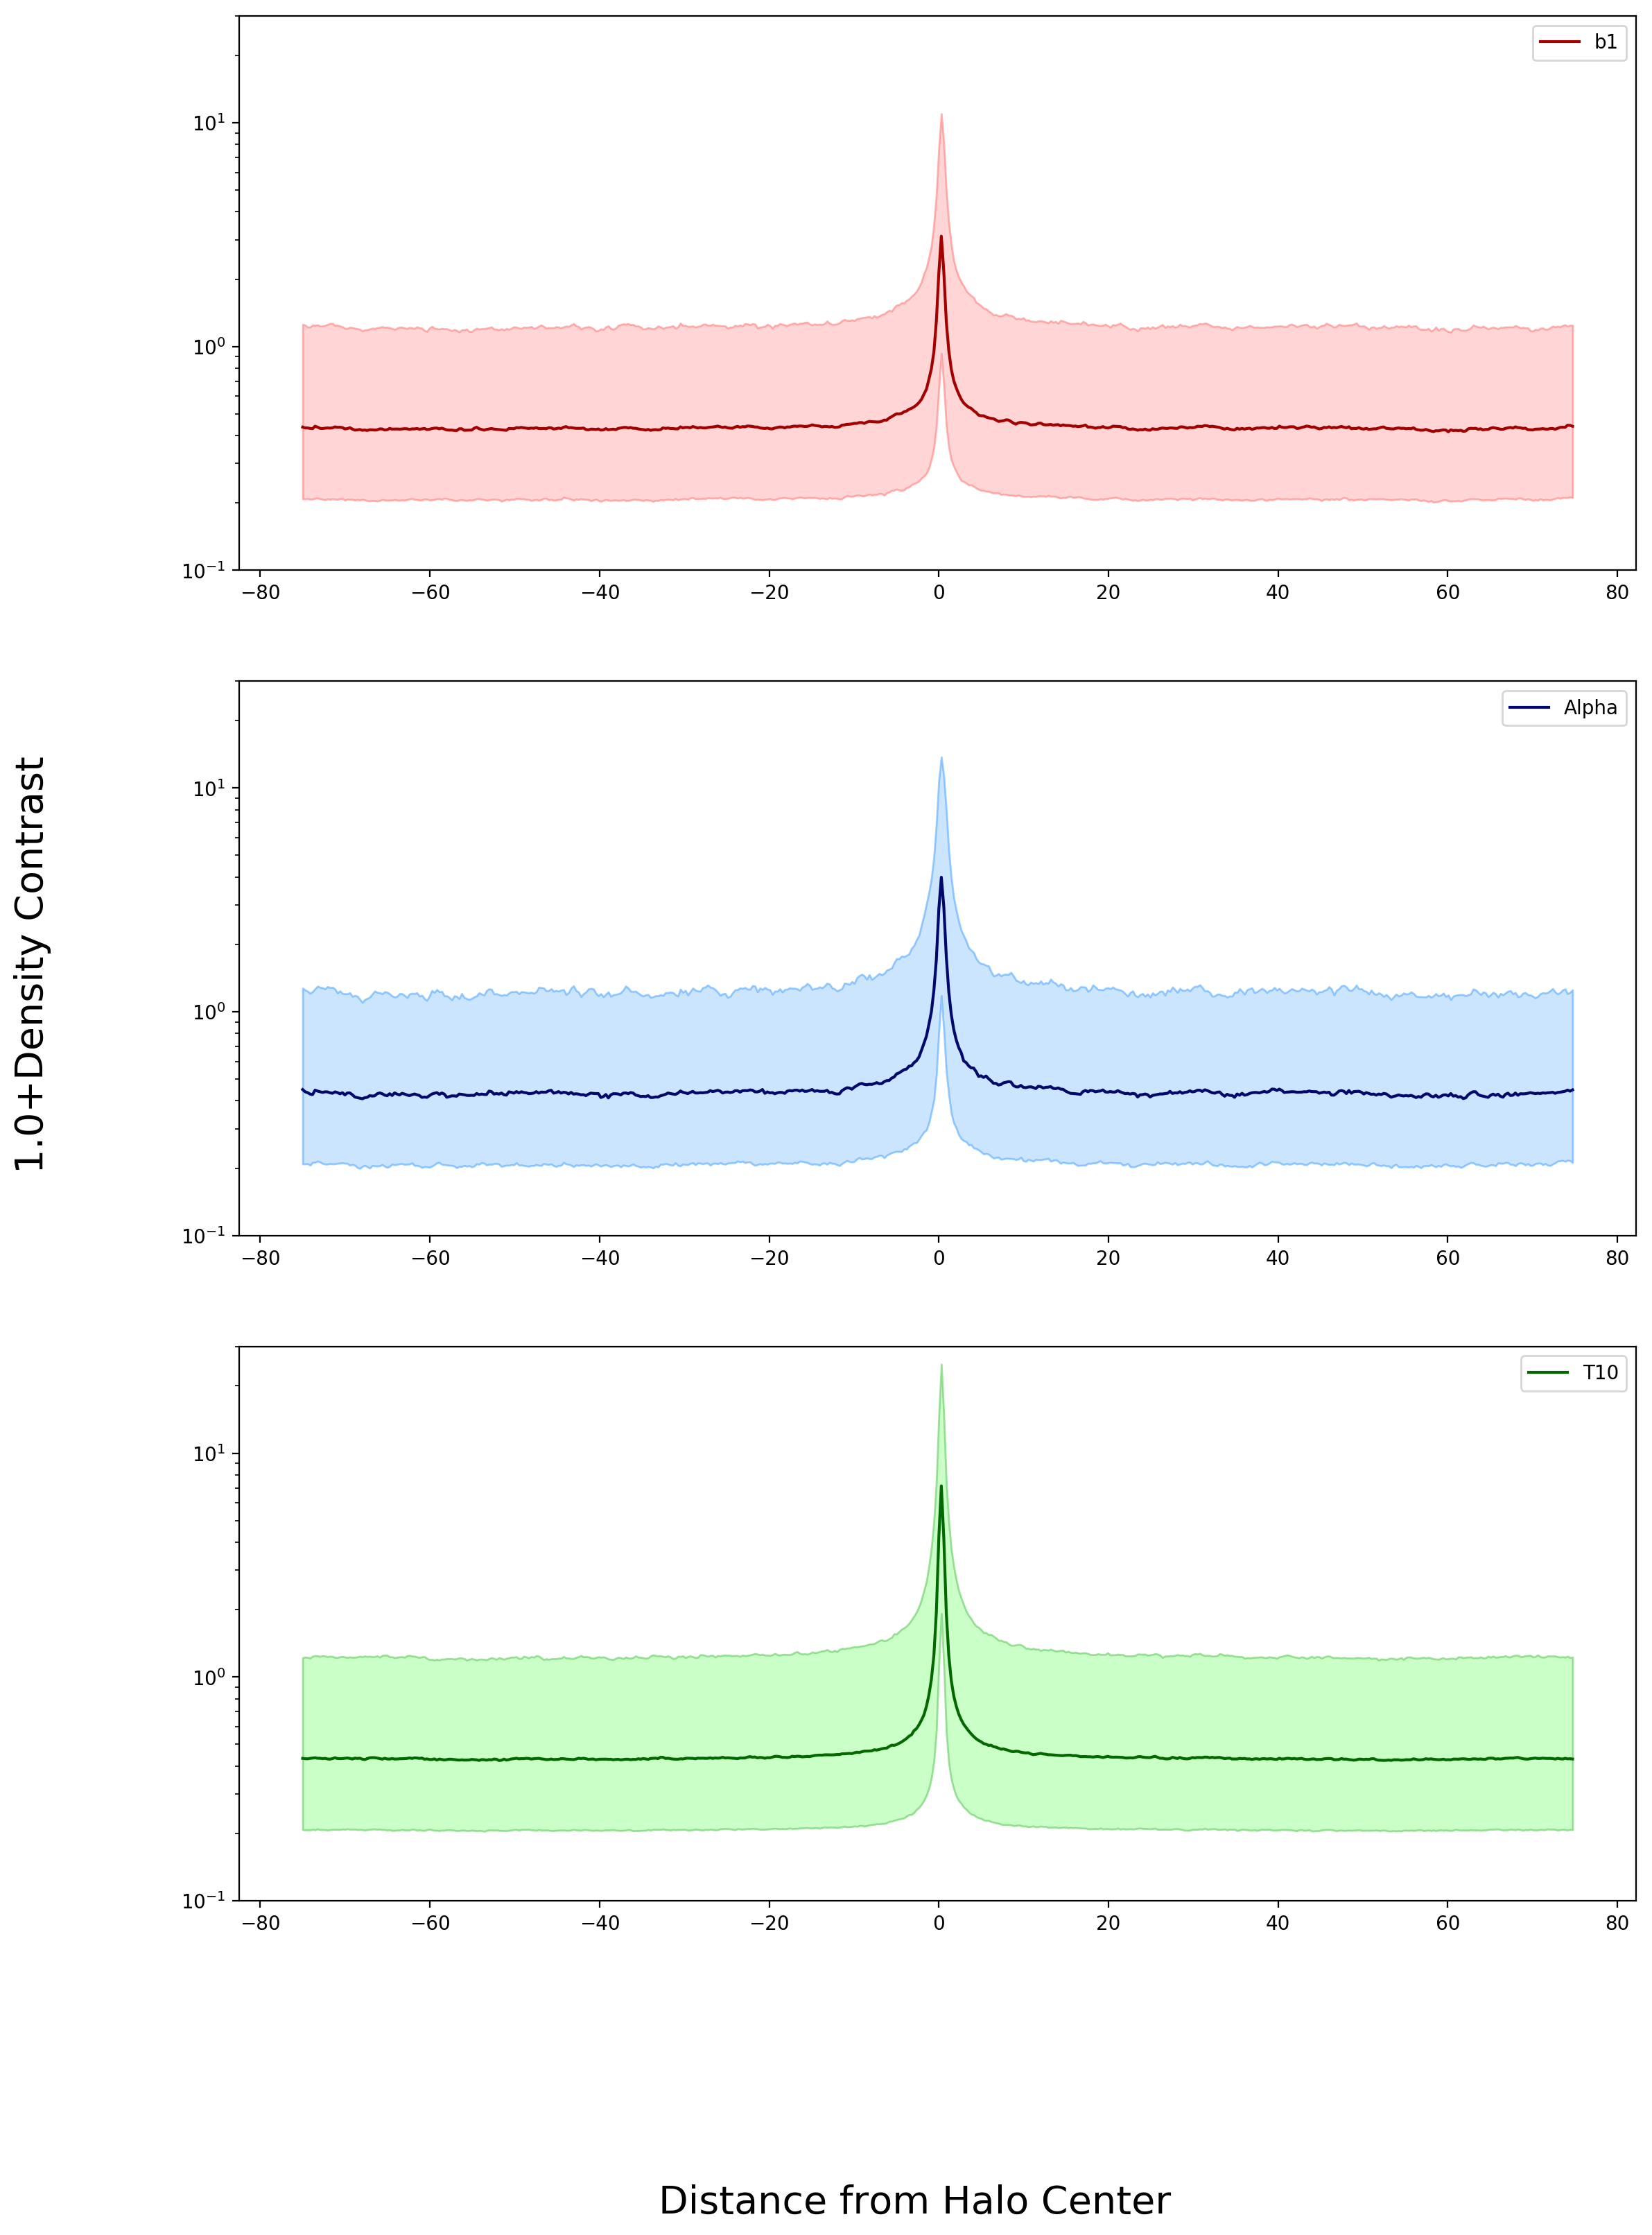

In [22]:
# This cell is specifically made to run the averagedLOSv2() function because of more complex plotting details.

fig,ax=plt.subplots(nrows=3, ncols=1, sharex=True, sharey=True, figsize=(13,18),dpi=200)
fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
fig.text(0.0, 0.5, '1.0+Density Contrast', va='center', rotation='vertical',fontsize=20)

plt.subplot(3,1,1)
plt.plot(p_b1, df_b1, 'k', color='#A30000',label="b1")
plt.fill_between(p_b1, pt84_b1, pt16_b1,alpha=0.5, edgecolor='#FF6B6B', facecolor='#FFADAD')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,2)
plt.plot(p_alpha, df_alpha, 'k', color='#00086B',label="Alpha")
plt.fill_between(p_alpha, pt84_alpha, pt16_alpha,alpha=0.5, edgecolor='#3a9cff', facecolor='#9bcdff')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

plt.subplot(3,1,3)
plt.plot(p_t10, df_t10, 'k', color='#036800',label="T10")
plt.fill_between(p_t10, pt84_t10, pt16_t10,alpha=0.5, edgecolor='#49c145', facecolor='#96ff93')
plt.ylim([0.1,3e1])
plt.yscale('log')
plt.legend()

## linDensityLOS(i,d)
The statistics developed above for LOS analysis have a redundancy due to direction. The density field on either side of a halo of interest should not be treated separately if we believe in the isotropy of the Universe. Hence, a still beter estimate should be to analyse the denisty of the distribution around the halo of interest. This will become clear through the description of the following procedure-
<ol>
    <li>Lines of Sight are shot parallel to the grid through the centers of all the Halos of interest from a given mock catalogue and the overdensity amplitude is computed at every scale.</li>
    <li>A bracket of <i>L MPc</i> is introduced symmetrically around the Halo of interest. The average linear density of total amplitude enclosed in the bracket is found and plotted against scale. In the formula below <i>i</i> iterates over all grid points contained in the enclosing bracket imposed on the Halo environment.
        $$\lambda(L)=\dfrac{\sum_{i}A_i}{L}$$

</ol>

In [ ]:
# Towards better statistics
def linDensityLOS(fileIndex,direction='all')

In [ ]:
# find density in the environment of randomly picked halos
# type= simple | general | averaged

def Analyse(runs,type='averaged'):
    #plt.figure(0,figsize=(10,18),dpi=200, facecolor='w', edgecolor='k')
    #plt.title('Density field along L.O.S parallel to x-axis')
    Nrows=runs
    Ncols=len(fileNames)
    fig,ax=plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(16,28))
    fig.text(0.5, 0.0, 'Distance from Halo Center', ha='center',fontsize=20)
    fig.text(0.0, 0.5, 'Overdensity Amplitude', va='center', rotation='vertical',fontsize=20)
    
    for k in range(0,runs):
        haloList=pickHalo()
        grain=100
        for j in range(0,len(fileNames)):
            halo=haloList[j]
            pos,df=[],[]

            if(type=='general'):
                pos,df=generalLOS(halo)
            elif(type=='simple'):
                pos,df=simpleLOS(halo,direction='x')
            elif(type=='averaged'):
                #pos,df,varDF=averagedLOS(j,direction='all')
                pos,df=averagedLOS(j,direction='all')
            else:
                print("Please select a valid mode.\nAvailable modes are- simple | general | averaged")
                exit()

            plt.subplot(Nrows,Ncols,3*k+j+1)
            plt.plot(pos,df,color=colors[j],markersize=1)
            plt.ylim([-1,35])

    plt.show()

In [ ]:
N=10  # Number of Halos to comapre and plot
Analyse(N,type='averaged')